In [1]:
import sys
import os
from pathlib import Path
import math
import json
import awkward as ak
import numpy as np
import uproot
import boost_histogram as bh
import hist
from hist import Hist, intervals, axis
import matplotlib.pyplot as plt
from matplotlib import cycler
import mplhep as hep
from coffea import nanoevents, lookup_tools, util
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.nanoevents.methods import vector, candidate, nanoaod
from coffea.nanoevents.methods.vector import PtEtaPhiELorentzVector
from coffea.lookup_tools import extractor, evaluator
from coffea.analysis_tools import PackedSelection, Weights
import dask
import correctionlib
from dask import delayed
from dask.distributed import Client
from dask_jobqueue import HTCondorCluster


In [2]:
MAX_WORKERS = 250
CHUNKSIZE = 50_000
MAX_CHUNKS = None

In [3]:
@delayed(pure=True)
def get_tree(url):    
    return uproot.open(url)["Events"]

In [4]:
redirector = "root://cmsxrootd.hep.wisc.edu//store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"
redirector2 = "root://cmsxrootd.hep.wisc.edu//store/user/cgalloni/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"
#redirector17D = "/hdfs/store/user/cgalloni/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"

DYJetsArr = np.concatenate((
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-0To50_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-0To50_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133625/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-0To50_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-0To50_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133625/0001/NANO_NANO_{i}.root" for i in range( 1000 , 2000 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-0To50_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-0To50_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133625/0002/NANO_NANO_{i}.root" for i in range( 2000 , 2060 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133649/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133649/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1004 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133710/0000/NANO_NANO_{i}.root" for i in range( 1 , 400 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133735/0000/NANO_NANO_{i}.root" for i in range( 1 , 80 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133755/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133755/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1376 )],
    [redirector+f"/2018/MC/DYJetsToLL_LHEFilterPtZ-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/DYJetsToLL_LHEFilterPtZ-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/240704_133818/0000/NANO_NANO_{i}.root" for i in range( 1 , 107 )]
))
WJetsArr = np.concatenate((
    [redirector+f"/2018/MC/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/231225_152652/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/231225_152652/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1116 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/231225_152707/0000/NANO_NANO_{i}.root" for i in range( 1 , 149 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8_ext1-v2_otherPart/231225_153158/0000/NANO_NANO_{i}.root" for i in range( 1 , 153 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151948/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151948/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1253 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/231225_152721/0000/NANO_NANO_{i}.root" for i in range( 1 , 95 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_ext1-v2_otherPart/231225_153212/0000/NANO_NANO_{i}.root" for i in range( 1 , 354 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/231225_152003/0000/NANO_NANO_{i}.root" for i in range( 1 , 187 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8_ext1-v2_otherPart/231225_153115/0000/NANO_NANO_{i}.root" for i in range( 1 , 54 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/231225_152017/0000/NANO_NANO_{i}.root" for i in range( 1 , 177 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8_ext1-v2_otherPart/231225_153129/0000/NANO_NANO_{i}.root" for i in range( 1 , 128 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151934/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151934/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1418 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/231225_152032/0000/NANO_NANO_{i}.root" for i in range( 1 , 161 )],
    [redirector+f"/2018/MC/WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8_ext1-v2_otherPart/231225_153143/0000/NANO_NANO_{i}.root" for i in range( 1 , 120 )]
))

TTArr = np.concatenate((
    [redirector+f"/2018/MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/231225_152259/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/231225_152259/0001/NANO_NANO_{i}.root" for i in range( 1000 , 2000 )],
    [redirector+f"/2018/MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/231225_152259/0002/NANO_NANO_{i}.root" for i in range( 2000 , 3000 )],
    [redirector+f"/2018/MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/231225_152259/0003/NANO_NANO_{i}.root" for i in range( 3000 , 3070 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0001/NANO_NANO_{i}.root" for i in range( 1000 , 2000 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0002/NANO_NANO_{i}.root" for i in range( 2000 , 3000 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0003/NANO_NANO_{i}.root" for i in range( 3000 , 4000 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0004/NANO_NANO_{i}.root" for i in range( 4000 , 5000 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0005/NANO_NANO_{i}.root" for i in range( 5000 , 6000 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0006/NANO_NANO_{i}.root" for i in range( 6000 , 7000 )],
    [redirector+f"/2018/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/231225_152244/0007/NANO_NANO_{i}.root" for i in range( 7000 , 7196 )],
    [redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0001/NANO_NANO_{i}.root" for i in range( 1000 , 2000 )],
    [redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0002/NANO_NANO_{i}.root" for i in range( 2000 , 3000 )],
    [redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0003/NANO_NANO_{i}.root" for i in range( 3000 , 4000 )],
    [redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0004/NANO_NANO_{i}.root" for i in range( 4000 , 5000 )],
    [redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0005/NANO_NANO_{i}.root" for i in range( 5000 , 5010 )]
))

VV_arr = np.concatenate((
    [redirector+f"/2018/MC/ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8/ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8/231225_152313/0000/NANO_NANO_{i}.root" for i in range( 1 , 428 )],
    [redirector+f"/2018/MC/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/231225_152328/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/231225_152328/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1915 )],
    [redirector+f"/2018/MC/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/231225_152342/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/231225_152342/0001/NANO_NANO_{i}.root" for i in range( 1000 , 2000 )],
    [redirector+f"/2018/MC/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/231225_152342/0002/NANO_NANO_{i}.root" for i in range( 2000 , 3000 )],
    [redirector+f"/2018/MC/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/231225_152342/0003/NANO_NANO_{i}.root" for i in range( 3000 , 3658 )],
    [redirector+f"/2018/MC/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/231225_152806/0000/NANO_NANO_{i}.root" for i in range( 1 , 141 )],
    [redirector+f"/2018/MC/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/231225_152821/0000/NANO_NANO_{i}.root" for i in range( 1 , 166 )],
    [redirector+f"/2018/MC/WWTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WWTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152850/0000/NANO_NANO_{i}.root" for i in range( 1 , 741 )],
    [redirector+f"/2018/MC/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152904/0000/NANO_NANO_{i}.root" for i in range( 1 , 142 )],
    [redirector+f"/2018/MC/WZTo1L3Nu_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo1L3Nu_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_153046/0000/NANO_NANO_{i}.root" for i in range( 1 , 68 )],
    [redirector+f"/2018/MC/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152919/0000/NANO_NANO_{i}.root" for i in range( 1 , 514 )],
    [redirector+f"/2018/MC/ZZTo2Nu2Q_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8/ZZTo2Nu2Q_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_153100/0000/NANO_NANO_{i}.root" for i in range( 1 , 49 )],
    [redirector+f"/2018/MC/ZZTo2Nu2Q_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8/ZZTo2Nu2Q_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_153100/0000/NANO_NANO_{i}.root" for i in range( 50 , 121 )],
    [redirector+f"/2018/MC/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152934/0000/NANO_NANO_{i}.root" for i in range( 1 , 598 )],
    [redirector+f"/2018/MC/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/231225_152835/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector+f"/2018/MC/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/231225_152835/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1318 )]
))

Data_arr = np.concatenate((
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018A-UL2018_MiniAODv2_GT36-v2/231222_133142/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018A-UL2018_MiniAODv2_GT36-v2/231222_133142/0001/NANO_NANO_{i}.root" for i in range( 1000 , 2000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018A-UL2018_MiniAODv2_GT36-v2/231222_133142/0002/NANO_NANO_{i}.root" for i in range( 2000 , 2963 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018B-UL2018_MiniAODv2_GT36-v2/231222_133202/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018B-UL2018_MiniAODv2_GT36-v2/231222_133202/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1370 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018C-UL2018_MiniAODv2_GT36-v3/231222_133222/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018C-UL2018_MiniAODv2_GT36-v3/231222_133222/0001/NANO_NANO_{i}.root" for i in range( 1000 , 1297 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018D-UL2018_MiniAODv2_GT36-v2/231222_133242/0000/NANO_NANO_{i}.root" for i in range( 1 , 1000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018D-UL2018_MiniAODv2_GT36-v2/231222_133242/0001/NANO_NANO_{i}.root" for i in range( 1000 , 2000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018D-UL2018_MiniAODv2_GT36-v2/231222_133242/0002/NANO_NANO_{i}.root" for i in range( 2000 , 3000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018D-UL2018_MiniAODv2_GT36-v2/231222_133242/0003/NANO_NANO_{i}.root" for i in range( 3000 , 4000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018D-UL2018_MiniAODv2_GT36-v2/231222_133242/0004/NANO_NANO_{i}.root" for i in range( 4000 , 5000 )],
    [redirector2+f"/2018/Data/SingleMu/SingleMuon/Run2018D-UL2018_MiniAODv2_GT36-v2/231222_133242/0005/NANO_NANO_{i}.root" for i in range( 5000 , 5591 )],
))
dy_fileset = {
    "DYJets": DYJetsArr.tolist(),
}
wjets_fileset = {
    "WJets": WJetsArr.tolist(),
}
TT_fileset = {
    "TT": TTArr.tolist(),
}
VV_fileset = {
    "VV": VV_arr.tolist(),
}
Data_fileset = {
    "Data": Data_arr.tolist(),
}
mt_fileset = {
    "DYJets": 
        DYJetsArr.tolist(),
    "WJets":
        WJetsArr.tolist(),
    "TT":
        TTArr.tolist(),
    "VV":
        VV_arr.tolist(),
    "Data": 
        Data_arr.tolist(),
}

inputs = []
for label in mt_fileset:
    input = [get_tree(url) for url in mt_fileset[label]]
    inputs = np.append(inputs, input)
inputs



#(redirector+f" /2018/MC/GluGluToBulkGravitonToHHTo2B2Tau_M-1250_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/GluGluToBulkGravitonToHHTo2B2Tau_M-1250_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/240505_231000/0000 /NANO_NANO_{i}.root" for i in range( 1 , 3 )),
#(redirector+f" /2018/MC/GluGluToBulkGravitonToHHTo2B2Tau_M-1500_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/GluGluToBulkGravitonToHHTo2B2Tau_M-1500_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/240505_231017/0000 /NANO_NANO_{i}.root" for i in range( 1 , 4 )),
#(redirector+f" /2018/MC/GluGluToBulkGravitonToHHTo2B2Tau_M-1750_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/GluGluToBulkGravitonToHHTo2B2Tau_M-1750_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/240505_231033/0000 /NANO_NANO_{i}.root" for i in range( 1 , 5 )),
#(redirector+f" /2018/MC/GluGluToBulkGravitonToHHTo2B2Tau_M-2000_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/GluGluToBulkGravitonToHHTo2B2Tau_M-2000_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/240505_231052/0000 /NANO_NANO_{i}.root" for i in range( 1 , 5 )),
#(redirector+f" /2018/MC/GluGluToBulkGravitonToHHTo2B2Tau_M-2500_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/GluGluToBulkGravitonToHHTo2B2Tau_M-2500_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/240505_231108/0000 /NANO_NANO_{i}.root" for i in range( 1 , 4 )),
#(redirector+f" /2018/MC/GluGluToBulkGravitonToHHTo2B2Tau_M-3000_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/GluGluToBulkGravitonToHHTo2B2Tau_M-3000_TuneCP5_PSWeights_narrow_13TeV-madgraph-pythia8/240505_231124/0000 /NANO_NANO_{i}.root" for i in range( 1 , 7 )),
#[redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-1000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-1000_TuneCP5_13TeV-madgraph-pythia8/231225_152357/0000/NANO_NANO_{i}.root" for i in range( 1 , 4 )],
#    [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-1200_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-1200_TuneCP5_13TeV-madgraph-pythia8/231225_152411/0000/NANO_NANO_{i}.root" for i in range( 1 , 4 )],
#    [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-1400_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-1400_TuneCP5_13TeV-madgraph-pythia8/231225_152425/0000/NANO_NANO_{i}.root" for i in range( 1 , 4 )],
#    [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-1600_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-1600_TuneCP5_13TeV-madgraph-pythia8/231225_152948/0000/NANO_NANO_{i}.root" for i in range( 1 , 8 )],
#   [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-1800_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-1800_TuneCP5_13TeV-madgraph-pythia8/231225_152440/0000/NANO_NANO_{i}.root" for i in range( 1 , 4 )],
#  [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/231225_152455/0000/NANO_NANO_{i}.root" for i in range( 1 , 5 )],
#  [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-2500_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-2500_TuneCP5_13TeV-madgraph-pythia8/231225_153003/0000/NANO_NANO_{i}.root" for i in range( 1 , 11 )],
#  [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-3000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-3000_TuneCP5_13TeV-madgraph-pythia8/231225_152509/0000/NANO_NANO_{i}.root" for i in range( 1 , 4 )],
#  [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-3500_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-3500_TuneCP5_13TeV-madgraph-pythia8/231225_152523/0000/NANO_NANO_{i}.root" for i in range( 1 , 4 )],
#  [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-4000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-4000_TuneCP5_13TeV-madgraph-pythia8/231225_152538/0000/NANO_NANO_{i}.root" for i in range( 1 , 4 )],
#  [redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-4500_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-4500_TuneCP5_13TeV-madgraph-pythia8/231225_152552/0000/NANO_NANO_{i}.root" for i in range( 1 , 5 )]
        

array([Delayed('get_tree-52f1628646a51866a86e37824ee85bd2'),
       Delayed('get_tree-eadf70a058e5bffbab5200926c14468d'),
       Delayed('get_tree-d887548e6236f14f1a29bb209ee9e32f'), ...,
       Delayed('get_tree-aa3220463eafc1c379b70ec081bb69e4'),
       Delayed('get_tree-1665ca780341a6cce1554f9ce9554aea'),
       Delayed('get_tree-8ee6898c383ba7642dc0fcc2b9498c38')], dtype=object)

In [5]:
ext = extractor()
ext.add_weight_sets(["IDCorr NUM_LooseID_DEN_genTracks_pt_abseta ./RunBCDEF_SF_ID.root", "Trg50Corr Mu50_OR_TkMu50_PtEtaBins/pt_abseta_ratio ./Trigger_EfficienciesAndSF_RunBtoF.root", "Trg27Corr IsoMu24_OR_IsoTkMu24_PtEtaBins/pt_abseta_ratio ./Trigger_EfficienciesAndSF_RunBtoF.root", "IsoCorr NUM_LooseRelIso_DEN_LooseID_pt_abseta ./RunBCDEF_SF_ISO.root", "pTCorr Ratio2D ./zmm_2d_2018.root"])
ext.finalize()
evaluator = ext.make_evaluator()

/opt/conda/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version <unknown>, this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
RuntimeError: The support for TGraph-types will be removed in a future coffea release. In case you need support for TGraph-type, please submit an issue to `https://github.com/CoffeaTeam/coffea/issues`.
  warnings.warn(message, FutureWarning)


In [6]:
evaluator_pu = correctionlib.CorrectionSet.from_file("./puWeights.json")

In [7]:
def bit_mask(bit):
      mask = 0
      mask += (1 << bit)
      return mask

In [8]:
def weightCalc(name):
      WScaleFactor = 1.21
      TT_FulLep_BR= 0.1061
      TT_SemiLep_BR= 0.4392
      TT_Had_BR= 0.4544

      if "Radion" in name: return 1
      elif "DYJets" in name:
         if "50To100" in name: return 397.4
         elif "100To250" in name: return 97.2
         elif "0To50" in name: return 1485
         elif "250To400" in name: return 3.701
         elif "400To650" in name: return 0.5086
         elif "650ToInf" in name: return 0.04728
         elif "100to200" in name: return 160.7
         elif "200to400" in name: return 48.63
         elif "400to600" in name: return 6.993
         elif "600to800" in name: return 1.761
         elif "800to1200" in name: return .8021
         elif "1200to2500" in name: return .1937
         elif "2500toInf" in name: return .003514
      elif "WJets" in name:
         if "100To200" in name: return 1256
         elif "70To100" in name: return 1264
         elif "200To400" in name: return 335.5
         elif "400To600" in name: return 45.25
         elif "600To800" in name: return 91.16
         elif "800To1200" in name: return 4.933
         elif "1200To2500" in name: return 1.16
         elif "2500ToInf" in name: return 0.008001 
      elif "QCD" in name:
         if "300to500" in name: return 347700
         elif "500to700" in name: return 32100
         elif "700to1000" in name: return 6831
         elif "1000to1500" in name: return 1207
         elif "1500to2000" in name: return 119.9
         elif "2000toInf" in name: return 25.24
      elif "ggH125" in name: return 48.30 * 0.0621
      elif "ggZHLL125" in name: return 0.1223 * 0.062 * 3 * 0.033658
      elif "ggZHNuNu125" in name: return 0.1223 * 0.062 * 0.2000
      elif "ggZHQQ125" in name: return 0.1223 * 0.062 * 0.6991
      elif "JJH0" in name:
         if "OneJet" in name: return 0.1383997884
         elif "TwoJet" in name: return 0.2270577971
         elif "ZeroJet" in name: return 0.3989964912
      elif "qqH125" in name: return 3.770 * 0.0621
      elif "Tbar-tchan" in name: return  26.23
      elif "Tbar-tW" in name: return 35.6
      elif "toptopH125" in name: return 0.5033 * 0.062
      elif "T-tchan.root" in name: return 44.07
      elif "T-tW" in name: return 35.6
      elif "TTT" in name:
         if "2L2Nu" in name: return 87.31
         if "Hadronic" in name: return 378.93
         if "SemiLeptonic" in name: return 364.35
      elif "VV2l2nu" in name: return 11.95
      elif "WMinus" in name: return 0.5272 * 0.0621
      elif "WPlus" in name: return 0.8331 * 0.0621
      elif "WZ" in name:
         if "1L1Nu" in name: return 10.71
         elif "1L3Nu" in name: return 3.05
         elif "2Q2L" in name: return 6.419
      elif "WWTo1L1Nu" in name: return 49.997
      elif "ZH125" in name: return 0.7544 * 0.0621
      elif "ZZTo2Q2L" in name: return 3.22
      elif "ZZTo4L" in name: return 1.325
      elif "ZZTo2Nu2Q" in name: return 4.04
      elif "RadionTohhTohtatahbb_narrow_M" in name:
         if "1000" in name: return
         elif "1000" in name: return 1
         elif "1200" in name: return 1
         elif "1400" in name: return 1
         elif "1600" in name: return 1
         elif "1800" in name: return 1
         elif "2000" in name: return 1
         elif "2500" in name: return 1
         elif "3000" in name: return 1
         elif "3500" in name: return 1
         elif "4000" in name: return 1
         elif "4500" in name: return 1
      elif "ST_t-channel" in name:
         if "4f_leptonDecays" in name: return 3.549
         elif "antitop_4f_InclusiveDecays" in name: return 69.09
         elif "top_4f_InclusiveDecays" in name: return 115.3
         elif "antitop_5f_inclusiveDecays" in name: return 34.97
         elif "top_5f_inclusiveDecays" in name: return 34.91
      else: print("Something's Wrong!")
      return 1.0

In [9]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        ak.behavior.update(nanoaod.behavior)
        self._accumulator = {}
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self,events):
        dataset = events.metadata["dataset"]

        ax = hist.axis.Regular(30, 0, 150, flow=False, name="mass", label=dataset)
        
        output = {}
        eventCount = len(events)
    
        output[dataset] =  {
            "mass": Hist(ax, storage=hist.storage.Weight()),
            "ss_mass": Hist(ax, storage=hist.storage.Weight()),
        }      
        
        
        name = str(events.metadata["filename"])
        XSection = weightCalc(name)

        electron = events.Electron
        ele_cut = (electron.pt >= 15) & (np.abs(electron.eta) <= 2.5)
        lowMVAele = electron[(np.abs(electron.eta) <= 0.8) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.83)
        midMVAele = electron[(np.abs(electron.eta) > 0.8) & (np.abs(electron.eta) <= 1.5) & (electron.mvaIso_WPL) & ele_cut] #electron.mvaFall17V2Iso > -0.77
        highMVAele = electron[(np.abs(electron.eta) >= 1.5) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.69)
        if not ak.any((ak.num(lowMVAele) == 0) & (ak.num(midMVAele) == 0) & (ak.num(highMVAele) == 0)): return output
        events = events[(ak.num(lowMVAele) == 0) & (ak.num(midMVAele) == 0) & (ak.num(highMVAele) == 0)]

        #Extra muon veto
        muon = events.Muon
        muon = muon[ak.num(muon) > 1]
        badMuon = muon[(np.abs(muon.pfRelIso04_all) > 0.3) & (muon[:,1].pt > 10) & (muon.tightId)] #tightId instead of bitwise thing
        if not ak.any((ak.num(muon) > 0) & (ak.num(badMuon) == 0)): return output
        events = events[(ak.num(muon) > 0) & (ak.num(badMuon) == 0)]

        #BJets
        jets = events.Jet
        goodJets= jets[(jets.jetId > 0.5) & (jets.pt > 30) & (np.abs(jets.eta) < 3.0)]
        HT = ak.sum(goodJets.pt, axis=-1)

        #BJet Veto 
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! change btagdeepflavb for each year https://btv-wiki.docs.cern.ch/ScaleFactors/UL2018/
        bJets = jets[(jets.btagDeepFlavB > .7100) & (jets.jetId > .5) & (jets.pt > 30) & (np.abs(jets.eta) < 2.4)]
        if not ak.any((ak.num(jets) > 0) & (HT > 200) & (ak.num(bJets) == 0)): return output
        events = events[(ak.num(jets) > 0) & (HT > 200) & (ak.num(bJets) == 0)]
        if not ak.any(events) or len(events) == 0:
            vismass = []
            ss_vismass = []
            output[dataset]["mass"].fill(mass=vismass)
            output[dataset]["ss_mass"].fill(mass=ss_vismass)
        if not ak.all((ak.num(events.Muon) > 0) & (ak.num(events.boostedTau) > 0), axis = -1):
            vismass = []
            ss_vismass = []
            output[dataset]["mass"].fill(mass=vismass)
            output[dataset]["ss_mass"].fill(mass=ss_vismass)
            return output
        mtEvents = events[ak.all((ak.num(events.Muon) > 0) & (ak.num(events.boostedTau) > 0), axis = -1)]
        muonC = mtEvents.Muon
        tauC = mtEvents.boostedTau
        metC = mtEvents.MET
        HLT = mtEvents.HLT
        
        muon = ak.zip( 
    	{
		"pt": muonC.pt,
        "eta": muonC.eta,
		"phi": muonC.phi,
		"mass": muonC.mass,
		},
    	with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
    	)
        
        tau = ak.zip( 
		{
		"pt": tauC.pt,
        "eta": tauC.eta,
        "phi": tauC.phi,
		"mass": tauC.mass,
		},
    	with_name="PtEtaPhiMLorentzVector",
    	behavior=vector.behavior,
    	)

        #Split into pairs
        pairs = ak.cartesian({'tau': tau, 'muon': muon}, nested=False)
        pairsC = ak.cartesian({'tau': tauC, 'muon': muonC}, nested=False)
        metPairs = ak.cartesian({'met': metC, 'muon': pairsC['muon']}, nested=False)
        PUPairs = ak.cartesian({'PU': np.rint(events.Pileup.nTrueInt), 'muon': pairsC['muon']}, nested=False)

        #Delta r cut
        dr = pairs['tau'].delta_r(pairs['muon'])
        #ID Cut
        MuID = (pairsC['muon'].tightId) & (np.abs(pairsC['muon'].dz) < 0.2)  # & (np.abs(pairsC['muon'].dxy) < 0.045)
        #Apply everything at once

        muTau_mask27 = ((np.abs(pairs['muon'].eta) < 2.4)
              & (MuID)
              & (pairs['muon'].pt >= 27)
              & (pairs['muon'].pt < 52)
              & (pairsC['muon'].pfRelIso04_all <= .3)
              & (metPairs['met'].pt > 30)
              & (pairs['tau'].pt > 30)
              & (HLT.Mu27)
              & (np.absolute(pairs['tau'].eta) < 2.3)
              & (pairsC['tau'].idAntiMu > 0)
              & (pairsC['tau'].idDecayModeOldDMs)
              & (dr > .1) 
              & (dr < .8))
        muTau_mask50 = ((np.abs(pairs['muon'].eta) < 2.4)
              & (MuID)
              & (pairs['muon'].pt >= 52)
              & (HLT.Mu50)
              & (pairs['tau'].pt > 30)
              & (np.absolute(pairs['tau'].eta) < 2.3)
              & (pairsC['tau'].idAntiMu > 0)
              & (pairsC['tau'].idDecayModeOldDMs)
              & (dr > .1) 
              & (dr < .8))
        
         #If everything cut return 0 (to avoid pointer errors)
        if not ak.any(muTau_mask27) and not ak.any(muTau_mask50):
            vismass = []
            ss_vismass = []
            output[dataset]["mass"].fill(mass=vismass)
            output[dataset]["ss_mass"].fill(mass=ss_vismass)
            return output
        
        pairs = pairs[(muTau_mask27) | (muTau_mask50)]
        pairsC = pairsC[(muTau_mask27) | (muTau_mask50)]
        metPairs = metPairs[(muTau_mask27) | (muTau_mask50)]
        PUPairs = PUPairs[(muTau_mask27) | (muTau_mask50)]

        #Separate based on charge
        pairs = pairs[pairsC['tau'].charge + pairsC['muon'].charge == 0]
        #SS_pairs = pairs[pairsC['tau'].charge + pairsC['muon'].charge != 0]
        pairsC = pairsC[pairsC['tau'].charge + pairsC['muon'].charge == 0]
        #SS_pairsC = pairsC[pairsC['tau'].charge + pairsC['muon'].charge != 0]

  
        
        #Separate based on trigger again
        pairs_50 = pairs[pairs['muon'].pt >= 52]
        pairs_27 = pairs[pairs['muon'].pt < 52]
        #SS_50 = SS_pairs[SS_pairs['muon'].pt >= 52]
        #SS_27 = SS_pairs[SS_pairs['muon'].pt < 52]

        
        pairs_50C = pairsC[pairs['muon'].pt >= 52]
        pairs_27C = pairsC[pairs['muon'].pt < 52]
        #SS_50C = SS_pairsC[SS_pairs['muon'].pt >= 52]
        #SS_27C = SS_pairsC[SS_pairs['muon'].pt < 52]
        
        #If everything cut return 0 (to avoid pointer errors)
        if ak.sum(pairs['muon'].mass) == 0:
            return output
                               
        
        #met50 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        met50 = metPairs[(pairs['muon'].pt >= 52)]
        
        #OSmet27 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        met27 = metPairs[(pairs['muon'].pt < 52)]
        #SSmet50 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        #SSmet50 = SSmet50[(SS_pairs['muon'].pt >= 52)]
        #SSmet27 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        #SSmet27 = SSmet27[(SS_pairs['muon'].pt < 52)]

        #OSPU50 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        PU50 = PUPairs[(pairs['muon'].pt >= 52)]
        #OSPU27 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        PU27 = PUPairs[(pairs['muon'].pt < 52)]
        #SSPU50 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        #SSPU50 = SSPU50[(SS_pairs['muon'].pt >= 52)]
        #SSPU27 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        #SSPU27 = SSPU27[(SS_pairs['muon'].pt < 52)]

        #TMass Cut
        tmass50 = np.sqrt(np.square(pairs_50['muon'].pt + met50['met'].pt) - np.square(pairs_50['muon'].px + met50['met'].pt * np.cos(met50['met'].phi)) - np.square(pairs_50['muon'].py + met50['met'].pt * np.sin(met50['met'].phi)))
        tmass27 = np.sqrt(np.square(pairs_27['muon'].pt + met27['met'].pt) - np.square(pairs_27['muon'].px + met27['met'].pt * np.cos(met27['met'].phi)) - np.square(pairs_27['muon'].py + met27['met'].pt * np.sin(met27['met'].phi)))

        if not ak.any(tmass50 < 80) and not ak.any(tmass27 < 80): return output
            
        pairs_50 = pairs_50[tmass50 < 80]
        pairs_27 = pairs_27[tmass27 < 80]
        pairs_50C = pairs_50C[tmass50 < 80]
        pairs_27C = pairs_27C[tmass27 < 80]

        met50 = met50[tmass50 < 80]
        met27 = met27[tmass27 < 80]
        PU50 = PU50[tmass50 < 80]
        PU27 = PU27[tmass27 < 80]

        OSmet50 = met50[(pairs_50C['tau'].charge + pairs_50C['muon'].charge == 0)]
        OSmet27 = met27[(pairs_27C['tau'].charge + pairs_27C['muon'].charge == 0)]
        SSmet50 = met50[(pairs_50C['tau'].charge + pairs_50C['muon'].charge != 0)]
        SSmet27 = met27[(pairs_27C['tau'].charge + pairs_27C['muon'].charge != 0)]

        OSPU50 = PU50[(pairs_50C['tau'].charge + pairs_50C['muon'].charge == 0)]
        OSPU27 = PU27[(pairs_27C['tau'].charge + pairs_27C['muon'].charge == 0)]
        SSPU50 = PU50[(pairs_50C['tau'].charge + pairs_50C['muon'].charge != 0)]
        SSPU27 = PU27[(pairs_27C['tau'].charge + pairs_27C['muon'].charge != 0)]
        #tmass50_SS = np.sqrt(np.square(SS_50['muon'].pt + SSmet50['met'].pt) - np.square(SS_50['muon'].px + SSmet50['met'].pt * np.cos(SSmet50['met'].phi)) - np.square(SS_50['muon'].py + SSmet50['met'].pt * np.sin(SSmet50['met'].phi)))
        #tmass27_SS = np.sqrt(np.square(SS_27['muon'].pt + SSmet27['met'].pt) - np.square(SS_27['muon'].px + SSmet27['met'].pt * np.cos(SSmet27['met'].phi)) - np.square(SS_27['muon'].py + SSmet27['met'].pt * np.sin(SSmet27['met'].phi)))

        
        #SS_50 = SS_50[tmass50_SS < 80]
        #SS_27 = SS_27[tmass27_SS < 80]
        #SS_50C = SS_50C[tmass50_SS < 80]
        #SS_27C = SS_27C[tmass27_SS < 80]

        #SSmet50 = SSmet50[tmass50_SS < 80]
        #SSmet27 = SSmet27[tmass27_SS < 80]
        #SSPU50 = SSPU50[tmass50_SS < 80]
        #SSPU27 = SSPU27[tmass27_SS < 80]
        
        #MET Vector
        MetVec27 =  ak.zip(
        {
        "pt": met27['met'].pt,
        "eta": 0,
        "phi": met27['met'].phi,
        "mass": 0,
        },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 
        MetVec50 =  ak.zip(
        {
         "pt": met50['met'].pt,
         "eta": 0,
         "phi": met50['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 
        MetVec27_OS =  ak.zip(
        {
        "pt": OSmet27['met'].pt,
        "eta": 0,
        "phi": OSmet27['met'].phi,
        "mass": 0,
        },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 
        MetVec50_OS =  ak.zip(
        {
         "pt": OSmet50['met'].pt,
         "eta": 0,
         "phi": OSmet50['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        )  
        
        MetVec27_SS =  ak.zip(
        {
         "pt": SSmet27['met'].pt,
         "eta": 0,
         "phi": SSmet27['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        )  
        MetVec50_SS =  ak.zip(
        {
         "pt": SSmet50['met'].pt,
         "eta": 0,
         "phi": SSmet50['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 
        
        
        #Make Z Vector
        ZVec27 = pairs_27['tau'].add(pairs_27['muon'])
        ZVec50 = pairs_50['tau'].add(pairs_50['muon'])
        if ak.sum(ZVec27.mass) == 0 and ak.sum(ZVec50.mass) == 0:
            vismass = []
            ss_vismass = []
            output[dataset]["mass"].fill(mass=vismass)
            output[dataset]["ss_mass"].fill(mass=ss_vismass)
            return output 
        
        #Make Higgs Vector
        Higgs50 = ZVec50.add(MetVec50)
        Higgs27 = ZVec27.add(MetVec27)  

        #Final ZVec Cuts
        ZVec50 = ZVec50[(ZVec50.pt > 200) & (Higgs50.pt > 250)]
        ZVec27 = ZVec27[(ZVec27.pt > 200) & (Higgs27.pt > 250)]
        if ak.sum(ZVec27.mass) == 0 and ak.sum(ZVec50.mass) == 0:
            return output 
            

        
        
        if ak.sum(ZVec27.mass) == 0 and ak.sum(ZVec50.mass) == 0: return output
        elif ak.sum(ZVec50.mass) == 0:
            OSpairs_27 = pairs_27[(pairs_27C['muon'].charge + pairs_27C['tau'].charge == 0)]
            OSpairs_27C = pairs_27C[pairs_27C['muon'].charge + pairs_27C['tau'].charge == 0]
            
            SSpairs_27 = pairs_27[pairs_27C['muon'].charge + pairs_27C['tau'].charge != 0]
            SSpairs_27C = pairs_27C[pairs_27C['muon'].charge + pairs_27C['tau'].charge != 0]
            
            ZVec27_OS = OSpairs_27['tau'].add(OSpairs_27['muon'])
            ZVec27_SS = SSpairs_27['tau'].add(SSpairs_27['muon'])

            Higgs27_OS = ZVec27_OS.add(MetVec27_OS) 
            Higgs27_SS = ZVec27_SS.add(MetVec27_SS)

            ZVec27_OS = ZVec27_OS[(ZVec27_OS.pt > 200) & (Higgs27_OS.pt > 250)]
            ZVec27_SS = ZVec27_SS[(ZVec27_SS.pt > 200) & (Higgs27_SS.pt > 250)]

            if not ak.any(ZVec27_SS.mass):
                vismass = ak.flatten(ZVec27_OS.mass, axis=-1)
                ss_vismass = []
            else:
                vismass = (ak.flatten(ZVec27_OS.mass, axis=-1))
                ss_vismass = (ak.flatten(ZVec27_SS.mass, axis=-1))

            shape = np.shape(vismass)
            SS_shape = np.shape(ss_vismass)
            
            if XSection != 1:
                #Luminosity (2018)
                luminosity = 59830.
                lumiWeight = (XSection * luminosity) / eventCount
    
                
                #Shortcut names to make things easier
                ZVec27pt = ak.flatten(ZVec27_OS.pt, axis=-1)
                ZVec27eta = ak.flatten(ZVec27_OS.eta, axis=-1)
                ZVec27_SSpt = ak.flatten(ZVec27_SS.pt, axis=-1)
                ZVec27_SSeta = ak.flatten(ZVec27_SS.eta, axis=-1)
                
                Mu27IsoCorr = evaluator["IsoCorr"](ZVec27pt, ZVec27eta)   #Iso
                Mu27TrgCorr = evaluator["Trg27Corr"](ZVec27pt, ZVec27eta) #Trigger
                Mu27IDCorr = evaluator["IDCorr"](ZVec27pt, ZVec27eta) #ID

                puTrue27 = np.array(ak.flatten(OSPU27['PU'][ZVec27.pt > 200], axis=-1), dtype=np.int8) #Pileup
                puWeight = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(puTrue27, 'nominal')

                Mu27IsoCorr_SS = evaluator["IsoCorr"](ZVec27_SSpt, ZVec27_SSeta)   
                Mu27TrgCorr_SS = evaluator["Trg27Corr"](ZVec27_SSpt, ZVec27_SSeta)   
                Mu27IDCorr_SS = evaluator["IDCorr"](ZVec27_SSpt, ZVec27_SSeta)  
               
                puTrue27_SS = np.array(ak.flatten(SSPU27['PU'][ZVec27_SS.pt > 200], axis=-1), dtype=np.int8)
                puWeight_SS = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(puTrue27_SS, 'nominal')

                if not ak.any(SS_shape):
                    weights_OS = Weights(len(shape))
                    weights_OS.add("MuIsoCorr", Mu27IsoCorr)
                    weights_OS.add("MuIDCorr", Mu27IDCorr)
                    weights_OS.add("MuTrgCorr", Mu27TrgCorr)
                    weights_OS.add("PUCorrection", puWeight)
                    if ("DYJets" in name): 
                        #Zpt correction
                        pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                        weights_OS.add("pTCorrection", pTCorrection27)
                    mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
                    weights_OS.add("lumiWeight", mass_w)
                    output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
                    output[dataset]["ss_mass"].fill(mass=ss_vismass)
                    return output

                if not ak.any(shape):
                    weights_SS = Weights(len(SS_shape))
                    weights_SS.add("MuIsoCorr", Mu27IsoCorr_SS)
                    weights_SS.add("MuIDCorr", Mu27IDCorr_SS)
                    weights_SS.add("MuTrgCorr", Mu27TrgCorr_SS)
                    weights_SS.add("PUCorrection", puWeight_SS) 
                    SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
                    weights_SS.add("lumiWeight", SS_mass_w)
                    output[dataset]["mass"].fill(mass=vismass)
                    output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
                    return output

                weights_OS = Weights(len(shape))
                weights_SS = Weights(len(SS_shape))
                
                weights_OS.add("MuIsoCorr", Mu27IsoCorr)
                weights_OS.add("MuIDCorr", Mu27IDCorr)
                weights_OS.add("MuTrgCorr", Mu27TrgCorr)
                weights_OS.add("PUCorrection", puWeight)
                
                weights_SS.add("MuIsoCorr", Mu27IsoCorr_SS)
                weights_SS.add("MuIDCorr", Mu27IDCorr_SS)
                weights_SS.add("MuTrgCorr", Mu27TrgCorr_SS)
                weights_SS.add("PUCorrection", puWeight_SS)
                
                #OS
                if ("DYJets" in name): 
                    pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                    weights_OS.add("pTCorrection", pTCorrection27)
                    
                #Get shape
                mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
                weights_OS.add("lumiWeight", mass_w)
    
                SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
                weights_SS.add("lumiWeight", SS_mass_w)
    
                output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
                output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
                
        elif ak.sum(ZVec27.mass) == 0: 
            OSpairs_50 = pairs_50[(pairs_50C['muon'].charge + pairs_50C['tau'].charge == 0)]
            OSpairs_50C = pairs_50C[pairs_50C['muon'].charge + pairs_50C['tau'].charge == 0]
            
            SSpairs_50 = pairs_50[pairs_50C['muon'].charge + pairs_50C['tau'].charge != 0]
            SSpairs_50C = pairs_50C[pairs_50C['muon'].charge + pairs_50C['tau'].charge != 0]
            
            ZVec50_OS = OSpairs_50['tau'].add(OSpairs_50['muon'])
            ZVec50_SS = SSpairs_50['tau'].add(SSpairs_50['muon'])

            Higgs50_OS = ZVec50_OS.add(MetVec50_OS) 
            Higgs50_SS = ZVec50_SS.add(MetVec50_SS)

            ZVec50_OS = ZVec50_OS[(ZVec50_OS.pt > 200) & (Higgs50_OS.pt > 250)]
            ZVec50_SS = ZVec50_SS[(ZVec50_SS.pt > 200) & (Higgs50_SS.pt > 250)]

            if not ak.any(ZVec50_SS.mass):
                vismass = (ak.flatten(ZVec50_OS.mass, axis=-1))
                ss_vismass = []
            else:
                vismass = (ak.flatten(ZVec50_OS.mass, axis=-1))
                ss_vismass = (ak.flatten(ZVec50_SS.mass, axis=-1))

            shape = np.shape(vismass)
            SS_shape = np.shape(ss_vismass)
            
            if XSection != 1:
                #Luminosity (2018)
                luminosity = 59830.
                lumiWeight = (XSection * luminosity) / eventCount
    
                
                #Shortcut names to make things easier
                ZVec50pt = ak.flatten(ZVec50_OS.pt, axis=-1)
                ZVec50eta = ak.flatten(ZVec50_OS.eta, axis=-1)
                ZVec50_SSpt = ak.flatten(ZVec50_SS.pt, axis=-1)
                ZVec50_SSeta = ak.flatten(ZVec50_SS.eta, axis=-1)
                
                Mu50IsoCorr = evaluator["IsoCorr"](ZVec50pt, ZVec50eta)   #Iso
                Mu50TrgCorr = evaluator["Trg50Corr"](ZVec50pt, ZVec50eta) #Trigger
                Mu50IDCorr = evaluator["IDCorr"](ZVec50pt, ZVec50eta) #ID

                puTrue50 = np.array(ak.flatten(OSPU50['PU'][ZVec50.pt > 200], axis=-1), dtype=np.int8) #Pileup
                puWeight = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(puTrue50, 'nominal')

                Mu50IsoCorr_SS = evaluator["IsoCorr"](ZVec50_SSpt, ZVec50_SSeta)   
                Mu50TrgCorr_SS = evaluator["Trg50Corr"](ZVec50_SSpt, ZVec50_SSeta)   
                Mu50IDCorr_SS = evaluator["IDCorr"](ZVec50_SSpt, ZVec50_SSeta)  
               
                puTrue50_SS = np.array(ak.flatten(SSPU50['PU'][ZVec50_SS.pt > 200], axis=-1), dtype=np.int8)
                puWeight_SS = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(puTrue50_SS, 'nominal')

                if not ak.any(SS_shape):
                    weights_OS = Weights(len(shape))
                    weights_OS.add("MuIsoCorr", Mu50IsoCorr)
                    weights_OS.add("MuIDCorr", Mu50IDCorr)
                    weights_OS.add("MuTrgCorr", Mu50TrgCorr)
                    weights_OS.add("PUCorrection", puWeight)
                    if ("DYJets" in name): 
                        #Zpt correction
                        pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)
                        weights_OS.add("pTCorrection", pTCorrection50)
                    mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
                    weights_OS.add("lumiWeight", mass_w)
                    output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
                    output[dataset]["ss_mass"].fill(mass=ss_vismass)
                    return output

                if not ak.any(shape):
                    weights_SS = Weights(len(SS_shape))
                    weights_SS.add("MuIsoCorr", Mu50IsoCorr_SS)
                    weights_SS.add("MuIDCorr", Mu50IDCorr_SS)
                    weights_SS.add("MuTrgCorr", Mu50TrgCorr_SS)
                    weights_SS.add("PUCorrection", puWeight_SS) 
                    SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
                    weights_SS.add("lumiWeight", SS_mass_w)
                    output[dataset]["mass"].fill(mass=vismass)
                    output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
                    return output
                
                weights_OS = Weights(len(shape))
                weights_SS = Weights(len(SS_shape))
                
                weights_OS.add("MuIsoCorr", Mu50IsoCorr)
                weights_OS.add("MuIDCorr", Mu50IDCorr)
                weights_OS.add("MuTrgCorr", Mu50TrgCorr)
                weights_OS.add("PUCorrection", puWeight)
                
                weights_SS.add("MuIsoCorr", Mu50IsoCorr_SS)
                weights_SS.add("MuIDCorr", Mu50IDCorr_SS)
                weights_SS.add("MuTrgCorr", Mu50TrgCorr_SS)
                weights_SS.add("PUCorrection", puWeight_SS)
                
                #OS
                if ("DYJets" in name): 
                    pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)
                    weights_OS.add("pTCorrection", pTCorrection50)
                    
                #Get shape
                mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
                weights_OS.add("lumiWeight", mass_w)
    
                SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
                weights_SS.add("lumiWeight", SS_mass_w)
    
                output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
                output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
                
        else:
            OSpairs_50 = pairs_50[(pairs_50C['muon'].charge + pairs_50C['tau'].charge == 0)]
            OSpairs_27 = pairs_27[pairs_27C['muon'].charge + pairs_27C['tau'].charge == 0]
            OSpairs_50C = pairs_50C[pairs_50C['muon'].charge + pairs_50C['tau'].charge == 0]
            OSpairs_27C = pairs_27C[pairs_27C['muon'].charge + pairs_27C['tau'].charge == 0]
            
            SSpairs_50 = pairs_50[pairs_50C['muon'].charge + pairs_50C['tau'].charge != 0]
            SSpairs_27 = pairs_27[pairs_27C['muon'].charge + pairs_27C['tau'].charge != 0]
            SSpairs_50C = pairs_50C[pairs_50C['muon'].charge + pairs_50C['tau'].charge != 0]
            SSpairs_27C = pairs_27C[pairs_27C['muon'].charge + pairs_27C['tau'].charge != 0]

            #Sign Splitting
            ZVec50_OS = OSpairs_50['tau'].add(OSpairs_50['muon'])
            ZVec27_OS = OSpairs_27['tau'].add(OSpairs_27['muon'])
            ZVec50_SS = SSpairs_50['tau'].add(SSpairs_50['muon'])
            ZVec27_SS = SSpairs_27['tau'].add(SSpairs_27['muon'])

            Higgs50_OS = ZVec50_OS.add(MetVec50_OS)
            Higgs27_OS = ZVec27_OS.add(MetVec27_OS) 
            Higgs50_SS = ZVec50_SS.add(MetVec50_SS)
            Higgs27_SS = ZVec27_SS.add(MetVec27_SS) 

            ZVec50_OS = ZVec50_OS[(ZVec50_OS.pt > 200) & (Higgs50_OS.pt > 250)]
            ZVec27_OS = ZVec27_OS[(ZVec27_OS.pt > 200) & (Higgs27_OS.pt > 250)]
            ZVec50_SS = ZVec50_SS[(ZVec50_SS.pt > 200) & (Higgs50_SS.pt > 250)]
            ZVec27_SS = ZVec27_SS[(ZVec27_SS.pt > 200) & (Higgs27_SS.pt > 250)]           

            if not ak.any(ZVec50_SS.mass) and not ak.any(ZVec27_SS.mass):
                vismass = np.append(ak.flatten(ZVec27_OS.mass, axis=-1), ak.flatten(ZVec50_OS.mass, axis=-1))
                ss_vismass = []
            elif not any(ZVec50_SS.mass):
                vismass = np.append(ak.flatten(ZVec27_OS.mass, axis=-1), ak.flatten(ZVec50_OS.mass, axis=-1))
                ss_vismass = ak.flatten(ZVec27_SS.mass, axis=-1)
            elif not any(ZVec27_SS.mass):
                vismass = np.append(ak.flatten(ZVec27_OS.mass, axis=-1), ak.flatten(ZVec50_OS.mass, axis=-1))
                ss_vismass = ak.flatten(ZVec50_SS.mass, axis=-1)
            else:
                vismass = np.append(ak.flatten(ZVec27_OS.mass, axis=-1), ak.flatten(ZVec50_OS.mass, axis=-1))
                ss_vismass = np.append(ak.flatten(ZVec27_SS.mass, axis=-1), ak.flatten(ZVec50_SS.mass, axis=-1))
            shape = np.shape(vismass)
            SS_shape = np.shape(ss_vismass)
            
            if XSection != 1:
                #Luminosity (2018)
                luminosity = 59830.
                lumiWeight = (XSection * luminosity) / eventCount
    
                
                #Shortcut names to make things easier
                ZVec50pt = ak.flatten(ZVec50_OS.pt, axis=-1)
                ZVec50eta = ak.flatten(ZVec50_OS.eta, axis=-1)
                ZVec50_SSpt = ak.flatten(ZVec50_SS.pt, axis=-1)
                ZVec50_SSeta = ak.flatten(ZVec50_SS.eta, axis=-1)
                ZVec27pt = ak.flatten(ZVec27_OS.pt, axis=-1)
                ZVec27eta = ak.flatten(ZVec27_OS.eta, axis=-1)
                ZVec27_SSpt = ak.flatten(ZVec27_SS.pt, axis=-1)
                ZVec27_SSeta = ak.flatten(ZVec27_SS.eta, axis=-1)

                Mu50IsoCorr = evaluator["IsoCorr"](ZVec50pt, ZVec50eta)   #Iso
                Mu50TrgCorr = evaluator["Trg50Corr"](ZVec50pt, ZVec50eta) #Trigger
                Mu50IDCorr = evaluator["IDCorr"](ZVec50pt, ZVec50eta) #ID
                Mu27IsoCorr = evaluator["IsoCorr"](ZVec27pt, ZVec27eta) 
                Mu27TrgCorr = evaluator["Trg27Corr"](ZVec27pt, ZVec27eta) 
                Mu27IDCorr = evaluator["IDCorr"](ZVec27pt, ZVec27eta) 
                
                puTrue50 = np.array(ak.flatten(OSPU50['PU'][ZVec50.pt > 200], axis=-1), dtype=np.int8) #Pileup
                puTrue27 = np.array(ak.flatten(OSPU27['PU'][ZVec27.pt > 200], axis=-1), dtype=np.int8)
                puWeight = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(np.append(puTrue27, puTrue50), 'nominal')

                Mu50IsoCorr_SS = evaluator["IsoCorr"](ZVec50_SSpt, ZVec50_SSeta)   
                Mu50TrgCorr_SS = evaluator["Trg50Corr"](ZVec50_SSpt, ZVec50_SSeta)   
                Mu50IDCorr_SS = evaluator["IDCorr"](ZVec50_SSpt, ZVec50_SSeta)  
                Mu27IsoCorr_SS = evaluator["IsoCorr"](ZVec27_SSpt, ZVec27_SSeta) 
                Mu27TrgCorr_SS = evaluator["Trg27Corr"](ZVec27_SSpt, ZVec27_SSeta)  
                Mu27IDCorr_SS = evaluator["IDCorr"](ZVec27_SSpt, ZVec27_SSeta) 
    
                puTrue50_SS = np.array(ak.flatten(SSPU50['PU'][ZVec50_SS.pt > 200], axis=-1), dtype=np.int8)
                puTrue27_SS = np.array(ak.flatten(SSPU27['PU'][ZVec27_SS.pt > 200], axis=-1), dtype=np.int8)
                puWeight_SS = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(np.append(puTrue27_SS, puTrue50_SS), 'nominal')

                if not ak.any(SS_shape):
                    weights_OS = Weights(len(shape))
                    weights_OS.add("MuIsoCorr", np.append(Mu27IsoCorr, Mu50IsoCorr))
                    weights_OS.add("MuIDCorr", np.append(Mu27IDCorr, Mu50IDCorr))
                    weights_OS.add("MuTrgCorr", np.append(Mu27TrgCorr, Mu50TrgCorr))
                    weights_OS.add("PUCorrection", puWeight)
                    if ("DYJets" in name): 
                        #Zpt correction
                        pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                        pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)
                        weights_OS.add("pTCorrection", np.append(pTCorrection27, pTCorrection50))
                    mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
                    weights_OS.add("lumiWeight", mass_w)
                    output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
                    output[dataset]["ss_mass"].fill(mass=ss_vismass)
                    return output

                if not any(shape):
                    weights_SS = Weights(len(SS_shape))
                    weights_SS.add("MuIsoCorr", np.append(Mu27IsoCorr_SS, Mu50IsoCorr_SS))
                    weights_SS.add("MuIDCorr", np.append(Mu27IDCorr_SS, Mu50IDCorr_SS))
                    weights_SS.add("MuTrgCorr", np.append(Mu27TrgCorr_SS, Mu50TrgCorr_SS))
                    weights_SS.add("PUCorrection", puWeight_SS) 
                    SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
                    weights_SS.add("lumiWeight", SS_mass_w)
                    output[dataset]["mass"].fill(mass=vismass)
                    output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
                    return output
                
                weights_OS = Weights(len(shape))
                weights_SS = Weights(len(SS_shape))
                
                weights_OS.add("MuIsoCorr", np.append(Mu27IsoCorr, Mu50IsoCorr))
                weights_OS.add("MuIDCorr", np.append(Mu27IDCorr, Mu50IDCorr))
                weights_OS.add("MuTrgCorr", np.append(Mu27TrgCorr, Mu50TrgCorr))
                weights_OS.add("PUCorrection", puWeight)
                
                weights_SS.add("MuIsoCorr", np.append(Mu27IsoCorr_SS, Mu50IsoCorr_SS))
                weights_SS.add("MuIDCorr", np.append(Mu27IDCorr_SS, Mu50IDCorr_SS))
                weights_SS.add("MuTrgCorr", np.append(Mu27TrgCorr_SS, Mu50TrgCorr_SS))
                weights_SS.add("PUCorrection", puWeight_SS)
                
                #OS
                if ("DYJets" in name): 
                    #Zpt correction
                    pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                    pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)
    
                    weights_OS.add("pTCorrection", np.append(pTCorrection27, pTCorrection50))
                #Get shape
                mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
                weights_OS.add("lumiWeight", mass_w)
    
                SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
                weights_SS.add("lumiWeight", SS_mass_w)
    
                output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
                output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
                return output 
            else:
                mass_w = np.full(shape=shape, fill_value=1.0, dtype=np.double)
                SS_mass_w = np.full(shape=SS_shape, fill_value=1.0, dtype=np.double)
                output[dataset]["mass"].fill(mass=vismass, weight=mass_w)
                output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=SS_mass_w)
        return output
        '''
        shape = np.shape(vismass)
        SS_shape = np.shape(ss_vismass)

        
        if XSection != 1:
            #Luminosity (2018)
            luminosity = 59830.
            lumiWeight = (XSection * luminosity) / eventCount

            
            #Shortcut names to make things easier
            ZVec50pt = ak.flatten(ZVec50_OS.pt, axis=-1)
            ZVec50eta = ak.flatten(ZVec50_OS.eta, axis=-1)
            ZVec50_SSpt = ak.flatten(ZVec50_SS.pt, axis=-1)
            ZVec50_SSeta = ak.flatten(ZVec50_SS.eta, axis=-1)
            ZVec27pt = ak.flatten(ZVec27_OS.pt, axis=-1)
            ZVec27eta = ak.flatten(ZVec27_OS.eta, axis=-1)
            ZVec27_SSpt = ak.flatten(ZVec27_SS.pt, axis=-1)
            ZVec27_SSeta = ak.flatten(ZVec27_SS.eta, axis=-1)

            
            #OS
            Mu50IsoCorr = evaluator["IsoCorr"](ZVec50pt, ZVec50eta)   #Iso
            Mu50TrgCorr = evaluator["Trg50Corr"](ZVec50pt, ZVec50eta) #Trigger
            Mu50IDCorr = evaluator["IDCorr"](ZVec50pt, ZVec50eta) #ID
            Mu27IsoCorr = evaluator["IsoCorr"](ZVec27pt, ZVec27eta) 
            Mu27TrgCorr = evaluator["Trg27Corr"](ZVec27pt, ZVec27eta) 
            Mu27IDCorr = evaluator["IDCorr"](ZVec27pt, ZVec27eta) 
            
            puTrue50 = np.array(ak.flatten(PU50['PU'][ZVec50.pt > 200], axis=-1), dtype=np.int8) #Pileup
            puTrue27 = np.array(ak.flatten(PU27['PU'][ZVec27.pt > 200], axis=-1), dtype=np.int8)
            puWeight = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(np.append(puTrue27, puTrue50), 'nominal')


            #SS
            Mu50IsoCorr_SS = evaluator["IsoCorr"](ZVec50_SSpt, ZVec50_SSeta)   
            Mu50TrgCorr_SS = evaluator["Trg50Corr"](ZVec50_SSpt, ZVec50_SSeta)   
            Mu50IDCorr_SS = evaluator["IDCorr"](ZVec50_SSpt, ZVec50_SSeta)  
            Mu27IsoCorr_SS = evaluator["IsoCorr"](ZVec27_SSpt, ZVec27_SSeta) 
            Mu27TrgCorr_SS = evaluator["Trg27Corr"](ZVec27_SSpt, ZVec27_SSeta)  
            Mu27IDCorr_SS = evaluator["IDCorr"](ZVec27_SSpt, ZVec27_SSeta) 

            puTrue50_SS = np.array(ak.flatten(SSPU50['PU'][ZVec50_SS.pt > 200], axis=-1), dtype=np.int8)
            puTrue27_SS = np.array(ak.flatten(SSPU27['PU'][ZVec27_SS.pt > 200], axis=-1), dtype=np.int8)
            puWeight_SS = evaluator_pu["Collisions18_UltraLegacy_goldenJSON"].evaluate(np.append(puTrue27_SS, puTrue50_SS), 'nominal')
            
            if not ak.any(SS_shape):
                weights_OS = Weights(len(shape))
                weights_OS.add("MuIsoCorr", np.append(Mu27IsoCorr, Mu50IsoCorr))
                weights_OS.add("MuIDCorr", np.append(Mu27IDCorr, Mu50IDCorr))
                weights_OS.add("MuTrgCorr", np.append(Mu27TrgCorr, Mu50TrgCorr))
                weights_OS.add("PUCorrection", puWeight)
                if ("DYJets" in name): 
                    #Zpt correction
                    pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                    pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)
                    weights_OS.add("pTCorrection", np.append(pTCorrection27, pTCorrection50))
                mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
                weights_OS.add("lumiWeight", mass_w)
                output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
                output[dataset]["ss_mass"].fill(mass=ss_vismass)
                return output

            if not ak.any(shape):
                weights_SS = Weights(len(SS_shape))
                weights_SS.add("MuIsoCorr", np.append(Mu27IsoCorr_SS, Mu50IsoCorr_SS))
                weights_SS.add("MuIDCorr", np.append(Mu27IDCorr_SS, Mu50IDCorr_SS))
                weights_SS.add("MuTrgCorr", np.append(Mu27TrgCorr_SS, Mu50TrgCorr_SS))
                weights_SS.add("PUCorrection", puWeight_SS) 
                SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
                weights_SS.add("lumiWeight", SS_mass_w)
                output[dataset]["mass"].fill(mass=vismass)
                output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
                return output
            
            weights_OS = Weights(len(shape))
            weights_SS = Weights(len(SS_shape))
            
            weights_OS.add("MuIsoCorr", np.append(Mu27IsoCorr, Mu50IsoCorr))
            weights_OS.add("MuIDCorr", np.append(Mu27IDCorr, Mu50IDCorr))
            weights_OS.add("MuTrgCorr", np.append(Mu27TrgCorr, Mu50TrgCorr))
            weights_OS.add("PUCorrection", puWeight)
            
            weights_SS.add("MuIsoCorr", np.append(Mu27IsoCorr_SS, Mu50IsoCorr_SS))
            weights_SS.add("MuIDCorr", np.append(Mu27IDCorr_SS, Mu50IDCorr_SS))
            weights_SS.add("MuTrgCorr", np.append(Mu27TrgCorr_SS, Mu50TrgCorr_SS))
            weights_SS.add("PUCorrection", puWeight_SS)
            
            #OS
            if ("DYJets" in name): 
                #Zpt correction
                pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)

                weights_OS.add("pTCorrection", np.append(pTCorrection27, pTCorrection50))


            #Get shape
            mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
            weights_OS.add("lumiWeight", mass_w)

            SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
            weights_SS.add("lumiWeight", SS_mass_w)

            output[dataset]["mass"].fill(mass=vismass, weight=weights_OS.weight())
            output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=weights_SS.weight())
            return output 
        else:
            output[dataset]["mass"].fill(mass=vismass)
            output[dataset]["ss_mass"].fill(mass=ss_vismass)
        return output 
        '''
    def postprocess(self, accumulator):
        return accumulator


In [10]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

In [11]:
PWD = os.getcwd()
print(f'Transferring contents of {PWD} to workers')
INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=1,
    memory="2 GB",
    disk="4 GB",
    death_timeout = '120',
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "+SingularityImage": '"/cvmfs/unpacked.cern.ch/registry.hub.docker.com/coffeateam/coffea-dask:0.7.22-py3.10-g7cbcc"',
        "Requirements": "HasSingularityJobStart",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path}'
        #"use_x509userproxy": "true",
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=10, maximum=MAX_WORKERS)
client = Client(cluster)
dask_executor = processor.DaskExecutor(client=client, status=True)
print("Executor created")

client

Transferring contents of /afs/hep.wisc.edu/user/emettner/rootProjects/Radion-DiHiggs-4Tau/NanoRun to workers
Condor logs, output files, error files in /scratch/emettner
Executor created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:25153,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
#DRELL-YAN
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=dask_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=120,
)

Creating runner
Using chunksize: 50000 and maxchunks None


In [13]:
#DRELL-YAN
print("Calling runner")
mt_results_dask = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Calling runner


RuntimeError: Work item WorkItem(dataset='VV', filename='root://cmsxrootd.hep.wisc.edu//store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23/2018/MC/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/231225_152835/0000/NANO_NANO_877.root', treename='Events', entrystart=0, entrystop=74000, fileuuid=b'\x80\xd3\xcdx\xa3\xea\x11\xee\xa9\xe2\x91\xbc\xe1\x83\xbe\xef', usermeta={}) caused a KilledWorker exception (likely a segfault or out-of-memory issue)

In [ ]:
client.shutdown()

2024-07-08 17:47:56,059 - distributed.core - ERROR - 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/utils.py", line 748, in wrapper
    return await func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/scheduler.py", line 6943, in feed
    await asyncio.sleep(interval)
  File "/opt/conda/lib/python3.10/asyncio/tasks.py", line 605, in sleep
    return await future
asyncio.exceptions.CancelledError


In [18]:
print(mt_results_dask)

NameError: name 'mt_results_dask' is not defined

In [20]:
for dset,results, in mt_results_dask.items():
    print(f"Dataset: {dset}")
    print(f"Result {results}")
    #print(f"Test: {results['Test'].value}")
    #print(f"Test 2: {results['Test2'].value}")
   # print(f"Event: {results['EventCount'].value}")


Dataset: DYJets
Result {'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='DYJets'), storage=Weight()) # Sum: WeightedSum(value=6358.44, variance=775343), 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='DYJets'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0)}
Dataset: TT
Result {'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='TT'), storage=Weight()) # Sum: WeightedSum(value=3364.96, variance=2.31512e+06), 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='TT'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0)}
Dataset: VV
Result {'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Weight()) # Sum: WeightedSum(value=89.0107, variance=1988.56), 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Weight()) # Sum: Weighted

/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f199fd0a1d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

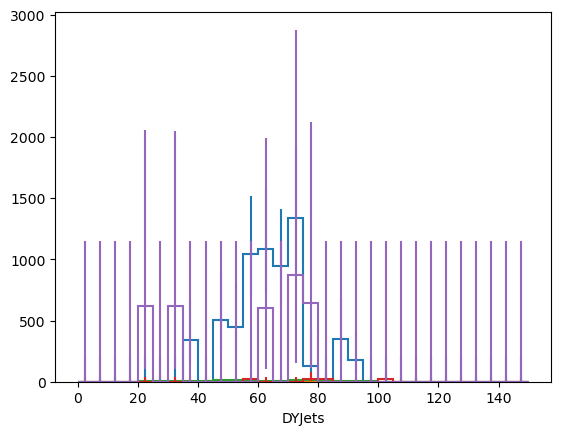

In [21]:
mt_results_dask["DYJets"]["mass"].plot()
mt_results_dask["WJets"]["mass"].plot()
mt_results_dask["Data"]["mass"].plot()
mt_results_dask["VV"]["mass"].plot()
mt_results_dask["TT"]["mass"].plot()

In [89]:
local_executor = processor.IterativeExecutor(status=True)

#Create the runner
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=local_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 100000 and maxchunks None


In [90]:
print("Calling runner")
mt_results_local = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Output()

Calling runner


Start:  1548   Data

Extra Ele Veto:  1109

Extra Mu Veto:  266

BJet Veto:  38

Pairs:  163  Vector:  163

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.49, 1.4, 1.03, 1.43, 0.14, 0.763, 0.763, ... 0.14, 0.14, 1.21, 1.21, 1.44, 1.44]

Start:  4445   Data

Extra Ele Veto:  3145

Extra Mu Veto:  616

BJet Veto:  149

Pairs:  623  Vector:  623

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.907, 0.14, 1.13, 1.26, ... 0.935, 0.935, 0.935, 0.935, 0.935, 0.935]

Start:  72238   Data

Extra Ele Veto:  50009

Extra Mu Veto:  9888

BJet Veto:  1932

Pairs:  7713  Vector:  7713

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.5, 0.942, 1.58, 0.14, 0.861, 1.45, 1.22, ... 1.32, 1.48, 0.14, 0.14, 1.28, 1.28]

Start:  71977   Data

Extra Ele Veto:  49834

Extra Mu Veto:  9512

BJet Veto:  1984

Pairs:  7934  Vector:  7934

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.6, 0.6, 0.6, 1.38, 1.38, 1.38, 1.18, ... 0.975, 0.975, 0.975, 0.889, 0.889, 0.889]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.13, 0.14, 0.725, 1.46, 0.638, 1.15, 1.29, ... 1.21, 1.38, 1.38, 1.55, 1.55, 0.14]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  47911   TT

Extra Ele Veto:  40934

Extra Mu Veto:  1684

BJet Veto:  308

Pairs:  610  Vector:  610

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 0.996, 0.996, 0.635, 0.635, ... 1.33, 0.986, 1.07, 1.25, 0.955, 1.21]

Start:  16485   WJets

Extra Ele Veto:  15345

Extra Mu Veto:  472

BJet Veto:  393

Pairs:  704  Vector:  704

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 1.21, 1.42, 0.956, 0.831, 1.3, 0.949, ... 1.58, 1.59, 1.23, 1.22, 1.36, 0.14]

Start:  16577   WJets

Extra Ele Veto:  15442

Extra Mu Veto:  450

BJet Veto:  372

Pairs:  676  Vector:  676

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.59, 1.03, 0.884, 1.22, 1.22, 1.15, 1.15, ... 1.35, 1.22, 0.14, 1.11, 1.41, 0.14]

Start:  10282   WJets

Extra Ele Veto:  9570

Extra Mu Veto:  297

BJet Veto:  254

Pairs:  466  Vector:  466

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.28, 1.28, 0.979, 0.979, 0.979, 0.979, ... 1.07, 1.07, 0.504, 0.504, 0.14, 1.29]

Start:  16625   WJets

Extra Ele Veto:  15486

Extra Mu Veto:  461

BJet Veto:  385

Pairs:  692  Vector:  692

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.31, 1.31, 0.865, 0.865, 1.16, 1.16, 0.14, ... 1.13, 1.32, 1.28, 0.901, 1.4, 1.49]

Start:  16771   WJets

Extra Ele Veto:  15685

Extra Mu Veto:  475

BJet Veto:  396

Pairs:  761  Vector:  761

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.35, 0.68, 1.54, 1.21, 1.2, 1.13, 0.833, ... 1.27, 0.14, 1.3, 0.525, 1.17, 0.607]

Start:  16916   WJets

Extra Ele Veto:  15730

Extra Mu Veto:  498

BJet Veto:  416

Pairs:  745  Vector:  745

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 1.44, 1.28, 1.22, 1.43, 1.31, 0.969, ... 1.36, 1.11, 0.14, 1.44, 1.55, 1.4]

Start:  16504   WJets

Extra Ele Veto:  15478

Extra Mu Veto:  439

BJet Veto:  381

Pairs:  692  Vector:  692

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.49, 1.12, 1.43, 0.14, 1.3, 1.33, 1.44, ... 1.23, 0.14, 1.59, 1.59, 0.14, 0.14]

Start:  16430   WJets

Extra Ele Veto:  15298

Extra Mu Veto:  427

BJet Veto:  365

Pairs:  624  Vector:  624

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.23, 1.41, 0.926, 0.14, 1.53, 1.04, 0.14, ... 1.54, 1.14, 0.935, 0.14, 1.08, 1.48]

Start:  8742   WJets

Extra Ele Veto:  8162

Extra Mu Veto:  252

BJet Veto:  218

Pairs:  373  Vector:  373

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 1.23, 0.14, 0.917, 1.38, 1.5, 0.14, ... 1.37, 0.14, 1.06, 0.53, 0.14, 0.935]

Start:  24984   DYJets

Extra Ele Veto:  23327

Extra Mu Veto:  6700

BJet Veto:  5920

Pairs:  12435  Vector:  12435

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.14, 1.1, 1.1, 0.629, 0.629, 0.895, ... 1.22, 1.22, 1.4, 1.4, 1.51, 1.51]

Start:  36710   DYJets

Extra Ele Veto:  34326

Extra Mu Veto:  9895

BJet Veto:  8809

Pairs:  18311  Vector:  18311

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.3, 1.2, 1.17, 0.14, 0.14, 1.01, 1.01, ... 0.14, 0.14, 0.14, 0.14, 0.895, 0.895]

Start:  30542   DYJets

Extra Ele Veto:  28578

Extra Mu Veto:  8132

BJet Veto:  7076

Pairs:  14849  Vector:  14849

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.661, 0.661, 0.31, 0.31, 0.14, 0.14, 0.14, ... 1.3, 1.3, 1.12, 1.12, 1.25, 1.25]

Start:  30471   DYJets

Extra Ele Veto:  28584

Extra Mu Veto:  8268

BJet Veto:  7249

Pairs:  15332  Vector:  15332

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.828, 0.828, 0.936, 0.936, 0.14, 0.14, ... 1.12, 1.12, 0.14, 0.14, 1.35, 1.35]

Start:  30714   DYJets

Extra Ele Veto:  28724

Extra Mu Veto:  8446

BJet Veto:  7481

Pairs:  15821  Vector:  15821

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.955, 0.955, 1.6, 1.6, 1.15, 1.48, 1.51, ... 0.14, 0.14, 1.14, 1.14, 1.09, 1.09]

Start:  23206   DYJets

Extra Ele Veto:  21775

Extra Mu Veto:  6227

BJet Veto:  5476

Pairs:  11477  Vector:  11477

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.24, 0.448, 1.08, 0.14, 1.36, 0.14, 0.14, ... 1.47, 1.47, 1.3, 1.3, 1.13, 1.13]

Start:  25873   DYJets

Extra Ele Veto:  24213

Extra Mu Veto:  6903

BJet Veto:  6138

Pairs:  12925  Vector:  12925

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[1.45, 0.422, 0.14, 0.14, 1.48, 1.48, 0.14, ... 0.14, 1.18, 1.18, 1.42, 1.42, 1.22]

Start:  31084   DYJets

Extra Ele Veto:  29112

Extra Mu Veto:  8558

BJet Veto:  7539

Pairs:  16005  Vector:  16005

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.565, 0.565, 1.28, 1.28, 0.885, 1.38, 1.13, ... 1.25, 1.25, 0.14, 0.14, 1.36, 1.36]

Start:  4755   DYJets

Extra Ele Veto:  4468

Extra Mu Veto:  1263

BJet Veto:  1116

Pairs:  2311  Vector:  2311

[0.106, 0.106, 0.106, 0.106, 0.106, 0.106, ... 0.106, 0.106, 0.106, 0.106, 0.106]

[0.14, 0.887, 1.3, 1.3, 1.05, 1.05, 0.14, ... 0.814, 0.14, 0.525, 0.14, 1.22, 1.38]

In [21]:
for dset,results in mt_results_local.items():
    print(f"Dataset: {dset}")
    #print(f"Event count: {results['EventCount'].value}")

print(mt_results_local.items())


Dataset: Data
Dataset: VV
Dataset: TT
Dataset: WJets
Dataset: DYJets
dict_items([('Data', {'Test': value_accumulator(int, 4), 'Test2': value_accumulator(int, 8), 'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Weight()) # Sum: WeightedSum(value=952, variance=952), 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'EventCount': value_accumulator(int, 100000)}), ('VV', {'Test': value_accumulator(int, 9), 'Test2': value_accumulator(int, 18), 'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'EventCount': value_accumulator(int, 26676)}), ('TT', {'Test': value_accumulator(int, 9), 'T

/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


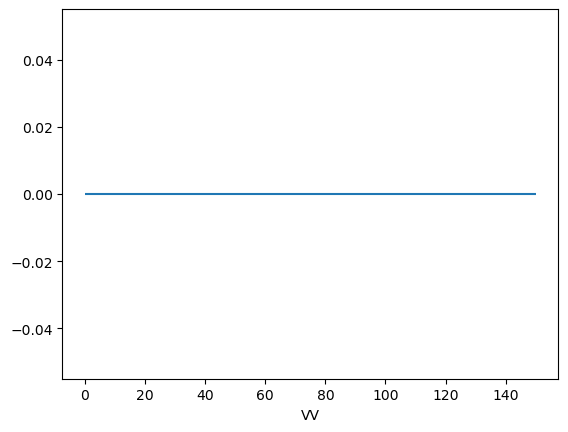

In [25]:
#mt_results_local["Data"]["mass"].plot()
#mt_results_local["DYJets"]["mass"].plot()
#mt_results_local["WJets"]["mass"].plot()
#mt_results_local["TT"]["mass"].plot()
mt_results_local["VV"]["mass"].plot()

Data_h, Data_bins = mt_results_local["Data"]["mass"].to_numpy()

In [22]:
d = {}
bins = np.linspace(0,150,30)

QCDScaleFactor = 1.6996559936491136

d["Data_h"], d["Data_bins"] = mt_results_dask["Data"]["mass"].to_numpy()
d["Data_SS_h"], d["Data_SS_bins"] = mt_results_dask["Data"]["ss_mass"].to_numpy()
labels1 = ["DYJets", "WJets", "TT", "VV"]
for i in labels1:
    d[i + "_h"], d[i + "_bins"] =  mt_results_dask[i]["mass"].to_numpy()
    d[i + "_SS_h"], d[i + "_SS_bins"] =  mt_results_dask[i]["ss_mass"].to_numpy()

d["QCD_h"] = np.subtract(np.subtract(np.subtract(d["Data_SS_h"], d["DYJets_SS_h"], dtype=object, out=None), d["WJets_SS_h"], dtype=object, out=None), d["TT_SS_h"], dtype=object, out=None)
for i in range(d["QCD_h"].size):
    if d["QCD_h"][i] < 0.0:
        d["QCD_h"][i] = 0.0
    d["QCD_w"] = np.full(shape=d["QCD_h"].shape, fill_value=QCDScaleFactor, dtype=np.double)
    d["QCD_hist"] = (d["QCD_h"], d["Data_SS_bins"])


In [23]:
outFile = uproot.recreate("boostedHTT_mt_2018_dask.input.root")
outFile["DYJets_met_1_13TeV/data_obs"] = mt_results_dask["Data"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/QCD"] = d["QCD_hist"]
outFile["DYJets_met_1_13TeV/WJets"] = mt_results_dask["WJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/DYJets125"] = mt_results_dask["DYJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/TT"] = mt_results_dask["TT"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/VV"] = mt_results_dask["VV"]["mass"].to_numpy()
outFile.close()

In [ ]:
outFile = uproot.recreate("boostedHTT_mt_2018.input.root")


